In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
from sklearn.manifold import TSNE

In [5]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator

from pytorch_lightning.loggers import CSVLogger

from estimator import TransformerEstimator

In [6]:
dataset = get_dataset("solar-energy")

In [9]:
estimator = TransformerEstimator(
        freq=dataset.metadata.freq,
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*6,
        
        scaling=True,
        num_feat_static_cat=len(dataset.metadata.feat_static_cat),
        cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
        embedding_dimension=[3],
        
        nhead=2,
        num_encoder_layers=4,
        num_decoder_layers=2,
        dim_feedforward=16,
        activation="gelu",
        
        batch_size=256,
        num_batches_per_epoch=200,
        trainer_kwargs=dict(gpus="1", max_epochs=39, logger=CSVLogger(".", "lightning_logs/")),
    )

In [10]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        num_workers=8,
    )

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus='1')` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices='1')` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 93.8 K
-------------------------------------------
93.8 K    Trainab

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 200: 'val_loss' reached 2.58357 (best 2.58357), saving model to './lightning_logs/version_405/checkpoints/epoch=0-step=200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 400: 'val_loss' reached 2.05740 (best 2.05740), saving model to './lightning_logs/version_405/checkpoints/epoch=1-step=400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 600: 'val_loss' reached 1.84159 (best 1.84159), saving model to './lightning_logs/version_405/checkpoints/epoch=2-step=600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 800: 'val_loss' reached 1.65660 (best 1.65660), saving model to './lightning_logs/version_405/checkpoints/epoch=3-step=800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 1000: 'val_loss' reached 1.61619 (best 1.61619), saving model to './lightning_logs/version_405/checkpoints/epoch=4-step=1000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 1200: 'val_loss' reached 1.43955 (best 1.43955), saving model to './lightning_logs/version_405/checkpoints/epoch=5-step=1200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 1400: 'val_loss' reached 1.33706 (best 1.33706), saving model to './lightning_logs/version_405/checkpoints/epoch=6-step=1400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 1600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 1800: 'val_loss' reached 1.31865 (best 1.31865), saving model to './lightning_logs/version_405/checkpoints/epoch=8-step=1800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 2000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 2200: 'val_loss' reached 1.24185 (best 1.24185), saving model to './lightning_logs/version_405/checkpoints/epoch=10-step=2200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 2400: 'val_loss' reached 1.20411 (best 1.20411), saving model to './lightning_logs/version_405/checkpoints/epoch=11-step=2400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 2600: 'val_loss' reached 1.14761 (best 1.14761), saving model to './lightning_logs/version_405/checkpoints/epoch=12-step=2600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 2800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 3000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 3200: 'val_loss' reached 0.89836 (best 0.89836), saving model to './lightning_logs/version_405/checkpoints/epoch=15-step=3200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 3400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 3600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 3800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 4000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 4200: 'val_loss' reached 0.74293 (best 0.74293), saving model to './lightning_logs/version_405/checkpoints/epoch=20-step=4200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 4400: 'val_loss' reached 0.72019 (best 0.72019), saving model to './lightning_logs/version_405/checkpoints/epoch=21-step=4400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 4600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 4800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 5000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 5200: 'val_loss' reached 0.63668 (best 0.63668), saving model to './lightning_logs/version_405/checkpoints/epoch=25-step=5200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 5400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 5600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 5800: 'val_loss' was not in top 1
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [20]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [21]:
forecasts = list(forecast_it)

In [22]:
tss = list(ts_it)

In [23]:
evaluator = Evaluator()

In [24]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))


Running evaluation: 959it [00:00, 2901.96it/s]


In [25]:
agg_metrics

{'MSE': 1439.7785021344698,
 'abs_error': 451631.35514831543,
 'abs_target_sum': 708873.5020904541,
 'abs_target_mean': 30.799161543728452,
 'seasonal_error': 13.175128459742648,
 'MASE': 1.4967196113352543,
 'MAPE': 2.400330897114534,
 'sMAPE': 1.478526210635745,
 'MSIS': 7.134996943959528,
 'QuantileLoss[0.1]': 142146.76188990354,
 'Coverage[0.1]': 0.040754257907542585,
 'QuantileLoss[0.2]': 260862.78547930386,
 'Coverage[0.2]': 0.08806916927354883,
 'QuantileLoss[0.3]': 352075.78391844843,
 'Coverage[0.3]': 0.14446472019464723,
 'QuantileLoss[0.4]': 415893.51194500603,
 'Coverage[0.4]': 0.31586722280152935,
 'QuantileLoss[0.5]': 451631.3572952304,
 'Coverage[0.5]': 0.6083594021550227,
 'QuantileLoss[0.6]': 460693.72582033084,
 'Coverage[0.6]': 0.7268856447688565,
 'QuantileLoss[0.7]': 435433.0702090704,
 'Coverage[0.7]': 0.7620351060132081,
 'QuantileLoss[0.8]': 369658.06293736945,
 'Coverage[0.8]': 0.7958376781369482,
 'QuantileLoss[0.9]': 244660.05103902938,
 'Coverage[0.9]': 0.84

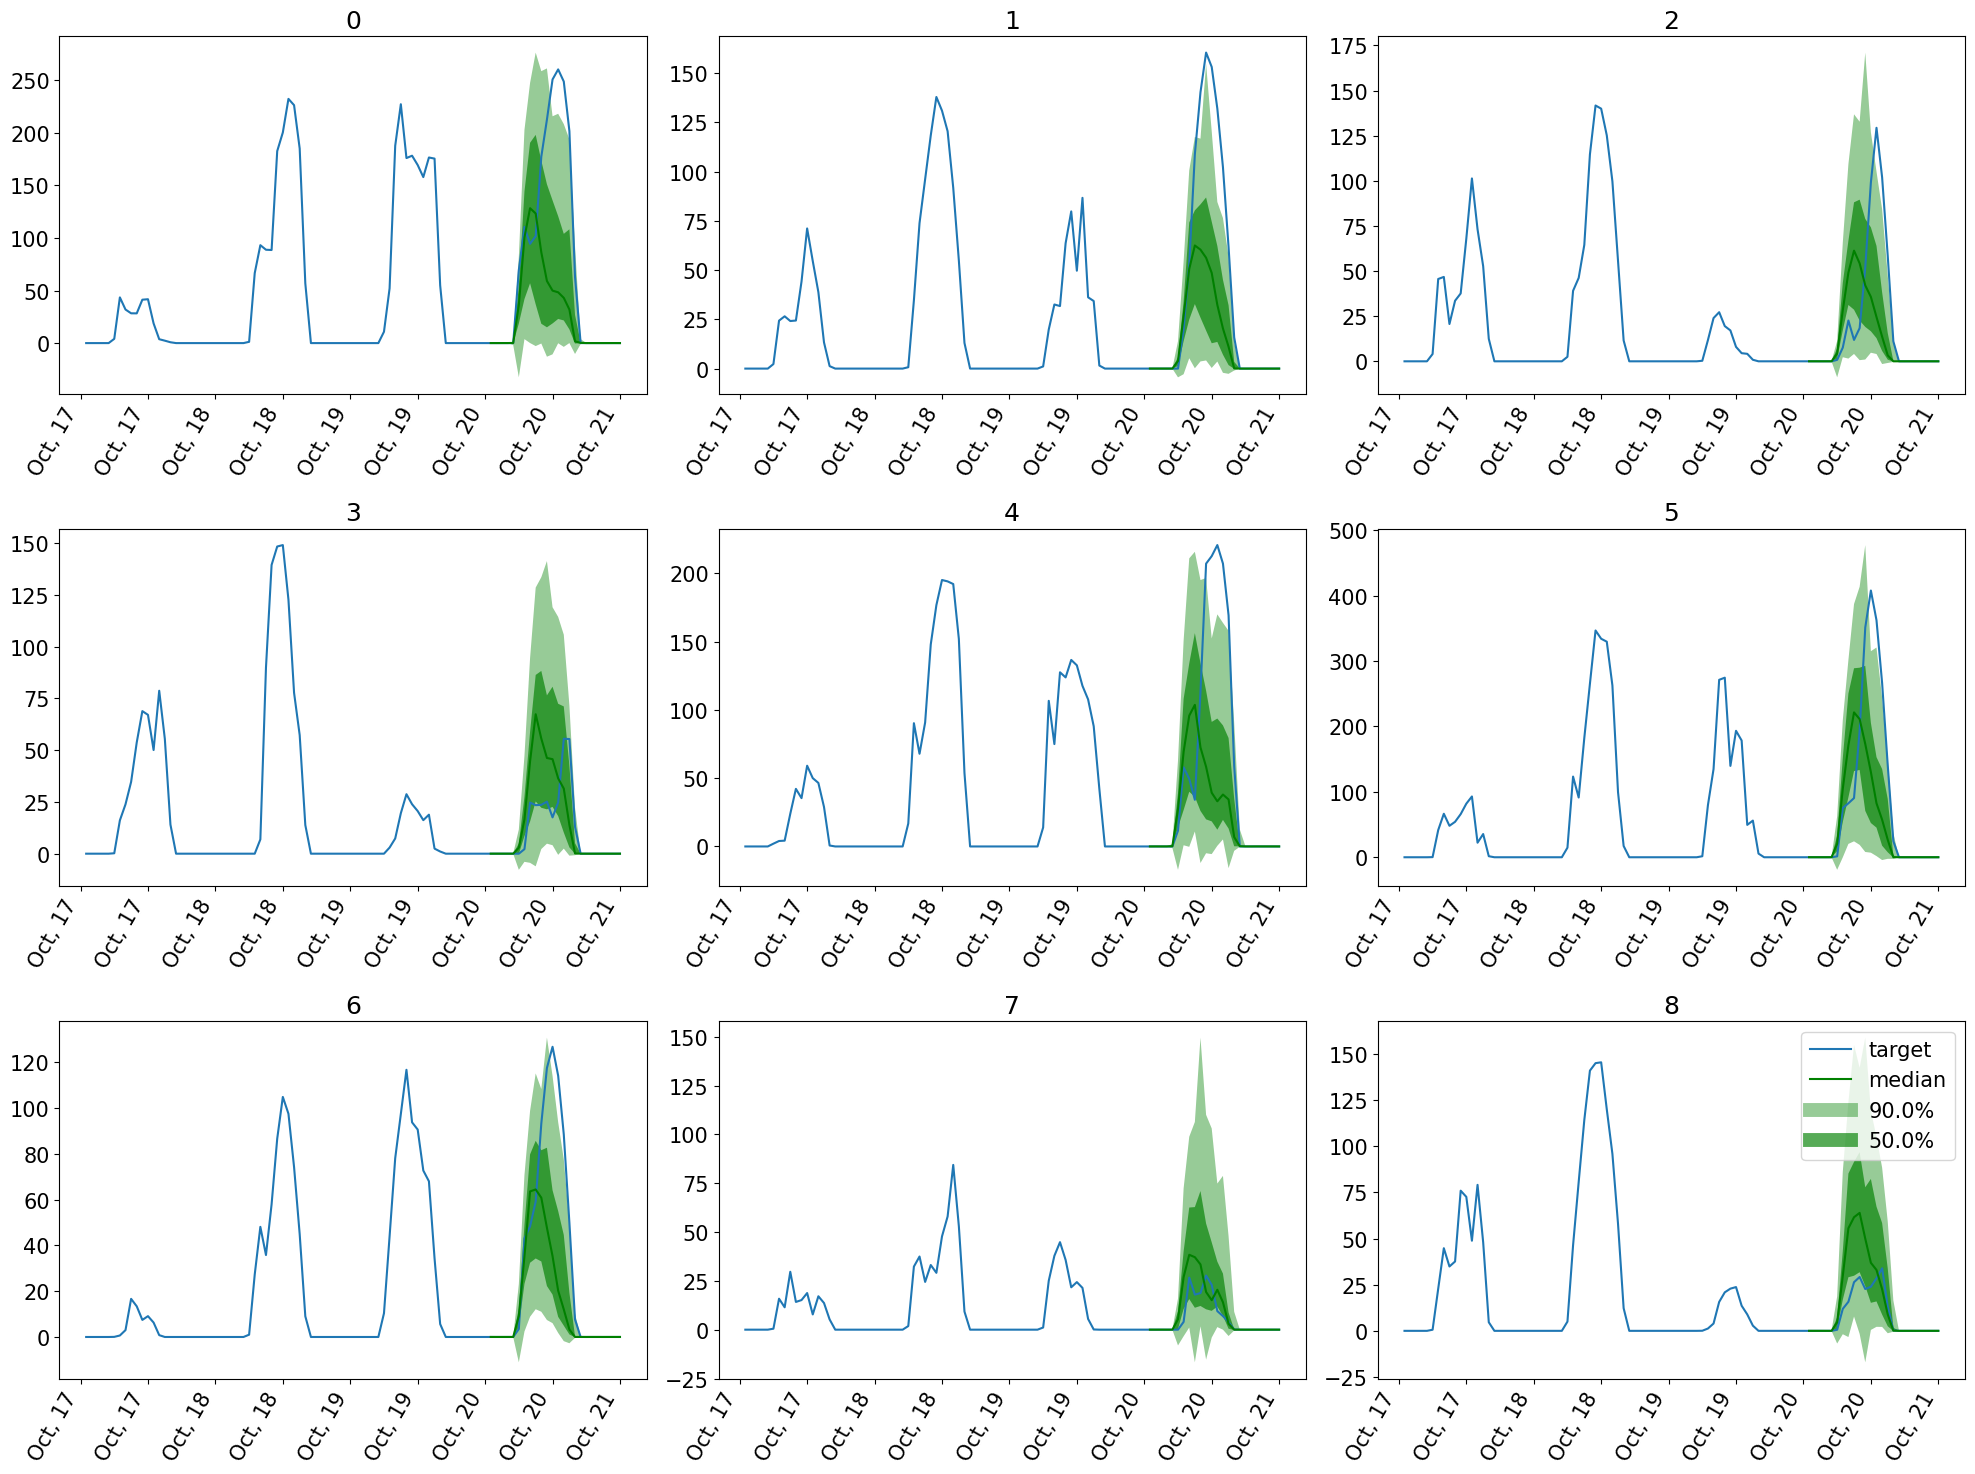

In [18]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [18]:
metrics = pd.read_csv("lightning_logs/version_86/metrics.csv")

In [19]:
metrics

,train_perplexity,epoch,step,val_loss,train_loss
0,2.042362,0,49,NaN,NaN
1,2.050069,0,99,NaN,NaN
2,2.743227,0,149,NaN,NaN
3,2.440984,0,199,NaN,NaN
4,NaN,0,199,4.355846,NaN
...,...,...,...,...,...
295,80.659866,49,9899,NaN,NaN
296,82.568138,49,9949,NaN,NaN
297,81.211136,49,9999,NaN,NaN
298,NaN,49,9999,1.084462,NaN


Text(0, 0.5, 'perplexity')

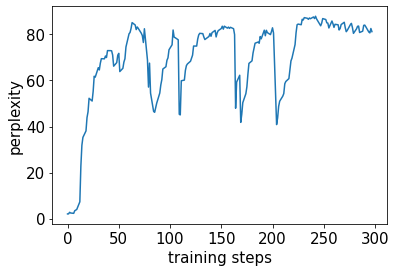

In [20]:
ax = metrics.train_perplexity.dropna().plot(kind="line")
ax.set_xlabel("training steps")
ax.set_ylabel("perplexity")

Text(0, 0.5, 'val neg. log likelihood')

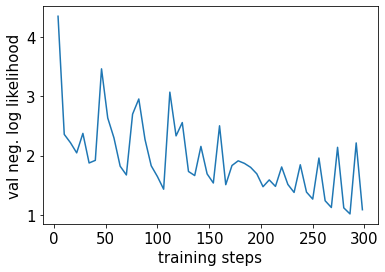

In [21]:
ax = metrics.val_loss.dropna().plot()
ax.set_xlabel("training steps")
ax.set_ylabel("val neg. log likelihood")

In [22]:
X = predictor.prediction_net.vq_vae.embed.cpu()

In [23]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

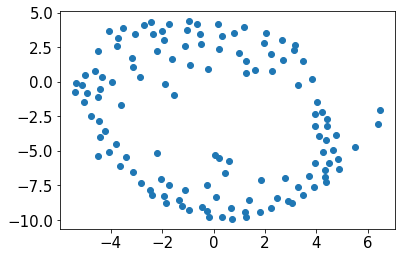

In [24]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], alpha=1.0)